In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

%matplotlib inline  
%config InlineBackend.figure_format = 'png'
pd.options.display.max_columns = None

seed_ = 42

**Пути к файлам**

In [2]:
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

**Имена колонок**

In [3]:
ID = 'Id'
AGE = 'age'
EXP = 'years_of_experience'
PRICE = 'lesson_price'
QLF = 'qualification'
PHYS = 'physics'
CHEM = 'chemistry'
BIO = 'biology'
ENG = 'english'
GEO = 'geography'
HIST = 'history'

TARGET = 'mean_exam_points'

NUM_COLS = [AGE, EXP, PRICE]

CAT_COLS = [QLF, PHYS, CHEM, BIO, ENG, GEO, HIST]

#NEW_CAT_COLS = [SCORE_CAT, NO_CREDIT, BIG_LOAN_AMOUNT]

### Чтение данных TRAIN

In [4]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


### Обзор данных

**Обзор целевой переменной**

In [6]:
df[TARGET].describe()

count    10000.000000
mean        64.340800
std         13.536823
min         32.000000
25%         55.000000
50%         63.000000
75%         73.000000
max        100.000000
Name: mean_exam_points, dtype: float64

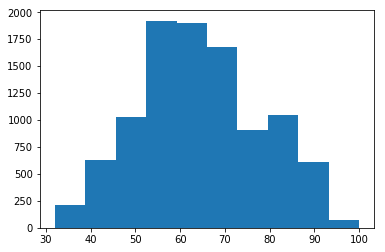

In [7]:
plt.hist(df[TARGET])
plt.show()

**Обзор категориальных признаков**

In [8]:
df[CAT_COLS].astype('str').describe()

,qualification,physics,chemistry,biology,english,geography,history
count,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,2,2,2,2
top,1.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,4884,6250,8671,8904,9463,9679,9806


**Обзор числовых признаков**

In [9]:
df[NUM_COLS].describe()

,age,years_of_experience,lesson_price
count,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000
std,8.043929,1.772213,524.886654
min,23.000000,0.000000,200.000000
25%,40.000000,0.000000,1300.000000
50%,46.000000,2.000000,1500.000000
75%,51.000000,3.000000,2150.000000
max,68.000000,10.000000,3950.000000


### Корреляционный анализ

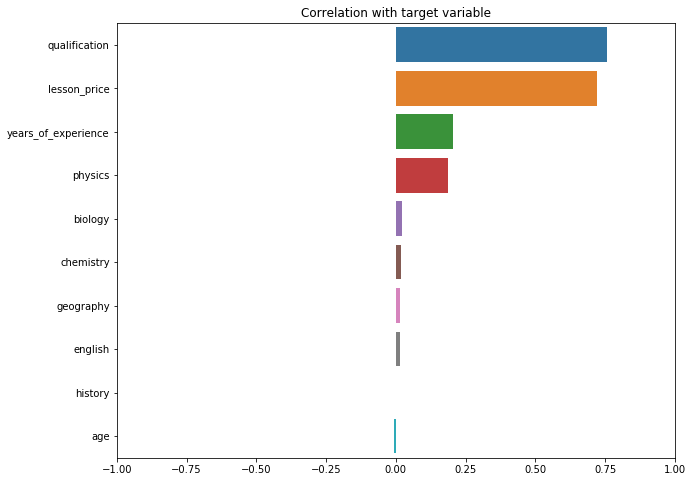

In [10]:
corr_with_target = df[NUM_COLS+CAT_COLS+[TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.xlim(-1.0, +1.0)
plt.title('Correlation with target variable')
plt.show()

In [11]:
corr = df[[TARGET]+NUM_COLS+CAT_COLS].corr()
corr.style.background_gradient(cmap='coolwarm')

,mean_exam_points,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
mean_exam_points,1,-0.00764635,0.205417,0.721179,0.755963,0.187726,0.0178251,0.0230216,0.013174,0.0144011,-0.000113295
age,-0.00764635,1,0.0599468,-0.00546203,-0.00097626,0.00404463,0.00125024,-0.00502595,-0.012546,0.0131304,0.0106063
years_of_experience,0.205417,0.0599468,1,0.248311,0.194097,0.00845061,0.00424597,-0.00172198,-0.0102412,-0.0111289,0.0186402
lesson_price,0.721179,-0.00546203,0.248311,1,0.790087,-0.00643209,0.00512955,-0.00486034,-0.0120181,0.0105251,-0.00114152
qualification,0.755963,-0.00097626,0.194097,0.790087,1,0.00752867,-0.002683,-0.00750434,-0.00804734,0.00360959,-0.00510943
physics,0.187726,0.00404463,0.00845061,-0.00643209,0.00752867,1,0.0198517,0.000661221,0.00423794,0.00190428,0.00486722
chemistry,0.0178251,0.00125024,0.00424597,0.00512955,-0.002683,0.0198517,1,0.00786601,0.00997423,-0.00444696,-0.00807879
biology,0.0230216,-0.00502595,-0.00172198,-0.00486034,-0.00750434,0.000661221,0.00786601,1,0.0101459,-0.0130423,0.0109955
english,0.013174,-0.012546,-0.0102412,-0.0120181,-0.00804734,0.00423794,0.00997423,0.0101459,1,-0.00814831,-0.00456002
geography,0.0144011,0.0131304,-0.0111289,0.0105251,0.00360959,0.00190428,-0.00444696,-0.0130423,-0.00814831,1,-0.00504861


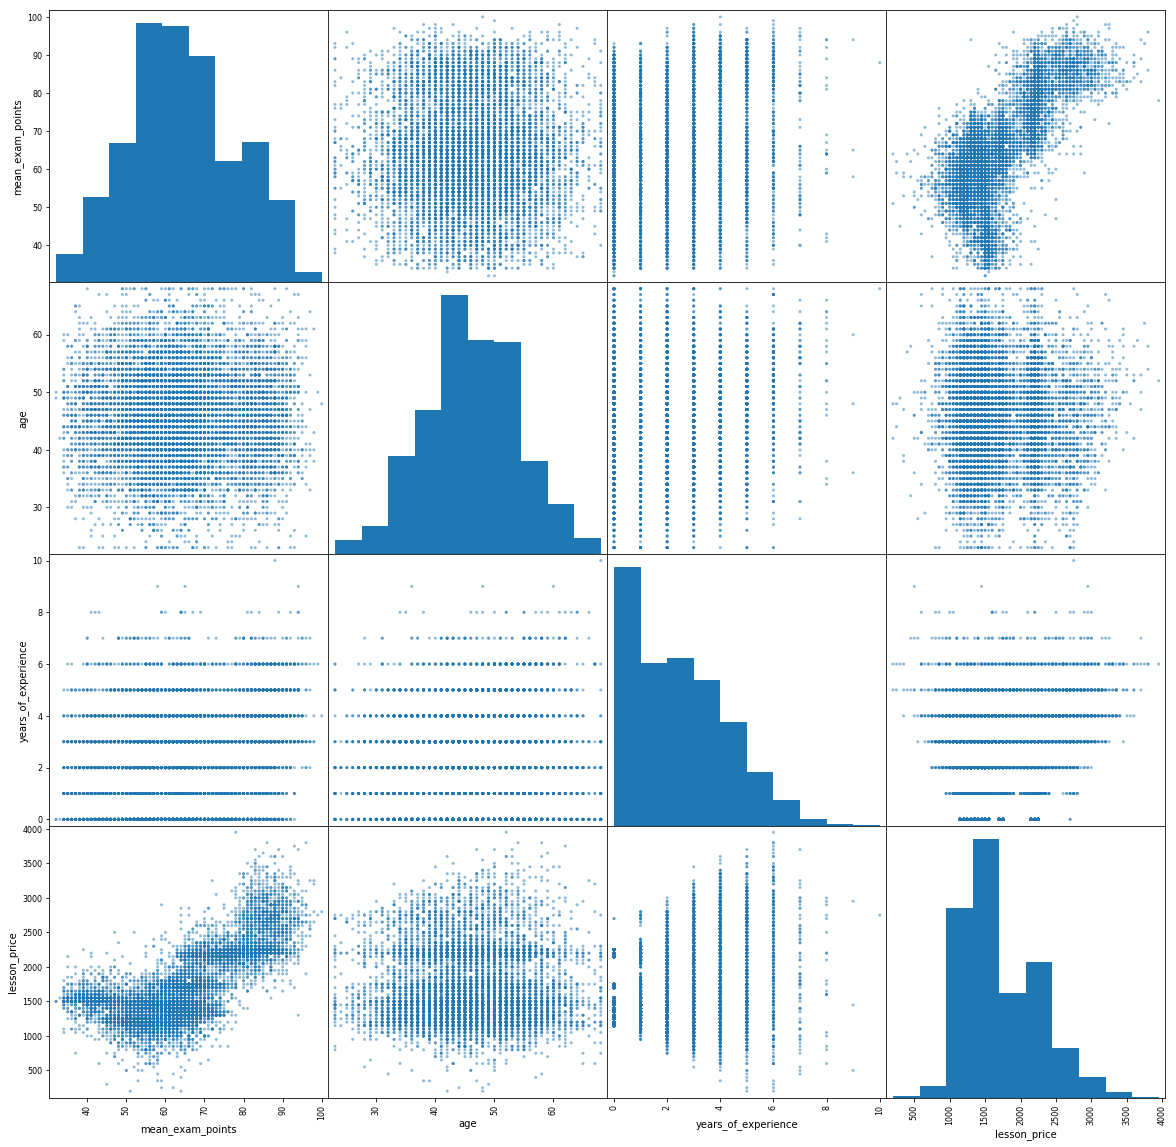

In [12]:
scatter_matrix(df[[TARGET]+NUM_COLS], figsize=(20, 20))
plt.show()

### Реализация алгоритма

In [13]:
def mae_score(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score

def neg_mae_score(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return -score

def mse_score(y_true, y_pred):
    score = np.mean(np.square(y_true - y_pred))
    return score

def neg_mse_score(y_true, y_pred):
    score = np.mean(np.square(y_true - y_pred))
    return -score

def medae_score(y_true, y_pred):
    score = np.median(np.abs(y_true - y_pred))
    return score

def neg_medae_score(y_true, y_pred):
    score = np.median(np.abs(y_true - y_pred))
    return -score

def r2_score(y_true, y_pred):
    true_mean = np.mean(y_true)
    score = 1 - np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - true_mean))
    return score

In [14]:
class Node:
    def __init__(self, index, threshold, true_branch, false_branch):
        self.index = index                # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.threshold = threshold        # значение порога
        self.true_branch = true_branch    # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    def predict_object(self, obj):
        if obj[self.index] <= self.threshold:
            return self.true_branch.predict_object(obj)
        else:
            return self.false_branch.predict_object(obj)        
    
    def predict(self, x):
        return np.array([self.predict_object(obj) for obj in x])
        
class Leaf:
    def __init__(self, y, avg_func=np.mean):
        self.prediction = avg_func(y)
        
    def predict_object(self, x):
        return self.prediction
        
def get_bootstrap(x, y, n):
    n_samples = x.shape[0]
    bootstrap = []
    
    for i in range(n):
        b_x = np.zeros(x.shape)
        b_y = np.zeros(y.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_x[j] = x[sample_index]
            b_y[j] = y[sample_index]
        bootstrap.append((b_x, b_y))
        
    return bootstrap

def quality(y_left, y_right, score, split_func):
    p = float(y_left.shape[0]) / (y_left.shape[0] + y_right.shape[0])
    return score - p * split_func(y_left) - (1 - p) * split_func(y_right)

def split(x, y, index, threshold):
    left = np.where(x[:, index] <= threshold)
    right = np.where(x[:, index] > threshold)
        
    x_true = x[left]
    x_false = x[right]
    y_true = y[left]
    y_false = y[right]
        
    return x_true, x_false, y_true, y_false

def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    random.shuffle(sample_indexes)
    
    subsample = []
    len_subsample = len_sample // 3
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    
    return subsample

def find_best_split(x, y, split_func, min_samples_leaf):
    score = split_func(y)

    best_quality = 0
    best_threshold = None
    best_index = None
    
    n_features = x.shape[1]
    
    #subsample = get_subsample(n_features)
    
    #for index in subsample:
    for index in range(n_features):
        t_values = np.unique([row[index] for row in x])
        
        for threshold in t_values:
            x_true, x_false, y_true, y_false = split(x, y, index, threshold)

            if len(x_true) < min_samples_leaf or len(x_false) < min_samples_leaf:
                continue
            
            current_quality = quality(y_true, y_false, score, split_func)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_threshold, best_index = current_quality, threshold, index

    return best_quality, best_threshold, best_index

def build_tree(x, y, split_func, max_depth, min_samples_split, min_samples_leaf, tol=1e-3):
    # max_depth - контроль глубины
    if max_depth == 0:
        return Leaf(y)

    # min_samples_split - контроль минимально необходимого количества объектов для разделения
    if len(x) < min_samples_split:
        return Leaf(y)

    # min_samples_leaf - контроль минимально необходимого количества объектов в листе
    quality, threshold, index = find_best_split(x, y, split_func, min_samples_leaf)

    # прекращаем рекурсию, когда нет прироста в качества
    if quality < tol:
        return Leaf(y)

    max_depth -= 1

    x_true, x_false, y_true, y_false  = split(x, y, index, threshold)

    # рекурсивно строим два поддерева
    true_branch = build_tree(x_true, y_true, split_func, max_depth, min_samples_split, min_samples_leaf)
    false_branch = build_tree(x_false, y_false, split_func, max_depth, min_samples_split, min_samples_leaf)

    # возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, threshold, true_branch, false_branch)
    
class RandomForestModel():
    def __init__(self, n_trees=10, split_func=np.var, max_depth=1e10, min_samples_split=2, min_samples_leaf=1, 
                 bootstrap=True, random_state=None):
        self.n_trees = n_trees
        self.split_func = split_func
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.forest = None
        
    def fit(self, x, y):
        random.seed(self.random_state)
        
        x = np.array(x)
        y = np.array(y)
    
        if self.bootstrap: 
            bootstrap = get_bootstrap(x, y, self.n_trees)
        else:
            bootstrap = [(x, y)]
    
        self.forest = []
        for b_x, b_y in bootstrap:
            self.forest.append(build_tree(b_x, b_y, self.split_func, self.max_depth, 
                                          self.min_samples_split, self.min_samples_leaf))
        
        return None
    
    def predict(self, x):
        if self.forest == None:
            return None
        
        x = np.array(x)

        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(x))

        predictions_per_object = list(zip(*predictions))

        y_pred = []
        for obj in predictions_per_object:
            y_pred.append(np.mean(obj))

        return y_pred

### Моделирование

In [15]:
FEAT_COLS = NUM_COLS+CAT_COLS

In [16]:
x = df[FEAT_COLS]
y = df[TARGET]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=seed_)

In [17]:
n_trees_list = [6, 7, 8, 9, 10, 11, 12]
max_depth_list = [6, 7, 8, 9, 10, 11, 12]
score_func = r2_score

In [18]:
best_score = -np.inf
best_params = {}
best_clf = None
for n_trees in n_trees_list:
    for max_depth in max_depth_list:
        print(n_trees, max_depth)
        clf = RandomForestModel(n_trees=n_trees, max_depth=max_depth, min_samples_leaf=5, random_state=seed_)
        %time clf.fit(x_train, y_train)
        y_train_pred = clf.predict(x_train)
        train_score = score_func(y_train, y_train_pred)
        y_test_pred = clf.predict(x_test)
        test_score = score_func(y_test, y_test_pred)
        print(train_score, test_score)
        if test_score > best_score:
            best_score = test_score
            best_params['n_trees'] = n_trees
            best_params['max_depth'] = max_depth
            best_clf = clf

6 6
Wall time: 3.73 s
0.7874330185666032 0.775227628503502
6 7
Wall time: 4.42 s
0.7962985740092923 0.7761440409590107
6 8
Wall time: 5.55 s
0.8046191952238324 0.7733604485652201
6 9
Wall time: 6.86 s
0.8130375318050019 0.7702323189336011
6 10
Wall time: 7.78 s
0.8214556425359854 0.7677554949243814
6 11
Wall time: 8.87 s
0.8297030162470009 0.7634015654194543
6 12
Wall time: 10.1 s
0.8369381937962357 0.7596992665748138
7 6
Wall time: 4.16 s
0.7878910639016667 0.7757706683408165
7 7
Wall time: 5.22 s
0.7969546392144538 0.7770094214412013
7 8
Wall time: 6.45 s
0.8052792993728819 0.7741809728804705
7 9
Wall time: 7.75 s
0.8137237884397918 0.7716132579640232
7 10
Wall time: 9.16 s
0.8223030879060975 0.7687189966725219
7 11
Wall time: 10.4 s
0.8308929649471433 0.7640161654370891
7 12
Wall time: 11.7 s
0.8382455233271355 0.7613085178864032
8 6
Wall time: 4.72 s
0.7882506635898577 0.775564475872168
8 7
Wall time: 5.73 s
0.7976053147893565 0.7767776228878065
8 8
Wall time: 7.37 s
0.806081730070

In [19]:
clf = best_clf
print(best_score, best_params)

0.7774130438359316 {'n_trees': 10, 'max_depth': 7}


### Предсказание

In [20]:
df_test = pd.read_csv(TEST_FILE)
df_test.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,10000,46.0,3.0,1050.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10001,43.0,3.0,1850.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,52.0,1.0,1550.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10003,57.0,6.0,2900.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0
4,10004,44.0,4.0,3150.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


In [22]:
%time df_test[TARGET] = clf.predict(df_test[FEAT_COLS])

Wall time: 422 ms


In [23]:
df_test.loc[:, ['Id', TARGET]].to_csv('VMaksimenko_predictions.csv', index=False)